<font  style="font-size: 4rem; color: darkviolet"> Convolutional Neural Networks in TensorFlow </font>

AA - 2022/23 - TP7

*This assignement is inspired by the Deep Learning course on Coursera by Andrew Ng, Stanford University, for which we are thankful.*

In this assignment, you will learn how to build and train Convolutional Neural Networks (ConvNets) using TensorFlow Keras API. You will be working on two different tasks. First, you will build a binary classifier using the Sequential API to classify the mood of a given person as either positive or negative. Next, you will build a multiclass classifier using the Functional API to identify sign language digits.

Before starting this assignment, you should have a basic understanding of TensorFlow.

You're encouraged to read the official documentation. You can find the docs for the Sequential and Functional APIs here:

https://www.tensorflow.org/guide/keras/sequential_model

https://www.tensorflow.org/guide/keras/functional


## Table of Contents
- [1 - The Sequential API](#1)
    - [1.1 - The Happy House Dataset](#1.1)
    - [1.2 - Create the Sequential Model](#1.2)
        - [Exercise 1.2.1 - happyModel](#ex-1.2.1)
    - [1.3 - Train and Evaluate the Model](#1.3)
- [2 - The Functional API](#2)
    - [2.1 - The SIGNS Dataset](#2.1)
    - [2.2 - Forward Propagation](#2.2)
        - [Exercise 2.2.1 - convolutional_model](#ex-2.2.1)
    - [2.3 - Train the Model](#2.3)
    - [2.4 - History](#2.4)
- [3 - Exercise - output volume](#ex-3) 

In [37]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy
from PIL import Image
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.python.framework import ops
from data.cnn_utils import *
from data.test_utils import summary, comparator

%matplotlib inline
np.random.seed(1)

# <a name='1'></a>
# <font color='darkviolet'> 1 - The Sequential API </font>

When it comes to practical applications of deep learning, programming frameworks are essential tools that offer a wide range of built-in functions to help you create and train models with ease. One such framework is Keras, which is a high-level abstraction built on top of TensorFlow that provides even more simplified and optimized model building and training.

You'll be using Keras' Sequential API to create a deep learning model. This API allows you to build models layer by layer, and is particularly well-suited for simple tasks where each layer has exactly one input tensor and one output tensor. Using the Sequential API is straightforward and easy to understand, making it a great choice for beginners.

<a name='1.1'></a>
## <font color='darkviolet'> 1.1 - The Happy House dataset  </font>

The Happy House dataset comprises images of individuals' faces, and your objective will be to create a ConvNet that can accurately identify whether these individuals are smiling or not. This is an important task because only those who are smiling will be granted entry into the Happy House.

In [38]:
def load_happy_dataset():
    # Load the training dataset
    train_dataset = h5py.File('data/train_happy.h5', "r")
    
    # Extract the features and labels for the training set
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # labels

    # Load the test dataset
    test_dataset = h5py.File('data/test_happy.h5', "r")
    
    # Extract the features and labels for the test set
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # labels

    # Extract the list of classes
    classes = np.array(test_dataset["list_classes"][:]) 
    
    # Reshape the labels to match the expected shape
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    # Return the dataset as a tuple
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [39]:
# Load the Happy House dataset
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_happy_dataset()

# Normalize the image vectors by dividing by 255
X_train = X_train_orig / 255.
X_test = X_test_orig / 255.

# Reshape the labels to match the expected shape (m, 1), where m is the number of examples
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T

In [40]:
# Print the shapes of the datasets and labels
print("Number of training examples = " + str(X_train.shape[0]))
print("Number of test examples = " + str(X_test.shape[0]))
print("X_train shape: " + str(X_train.shape))
print("Y_train shape: " + str(Y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("Y_test shape: " + str(Y_test.shape))

Number of training examples = 600
Number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


#### <font color='green'> Q1.1 Describe your dataset. </font>
>
> Q.1.1. 
> The trainset is composed of 600 pictures of 64x64 pixels and each pixel is composed of 3 integers. 
> The trainset is only composed of 150 pictures.
> The dataset has two labels: 0 and 1. 0 means the person is not smiling and 1 means the person is smiling.
>
> First we normalized the dataset by dividing by 255. Then we reshaped the dataset to have the shape (600, 64, 64, 3) and (150, 64, 64, 3) for the trainset and the testset respectively.
>
> Finally, we have both a trainset and a testset representing our 600 and 150 pictures by one vector.

<a name='1.2'></a>
## <font color='darkviolet'> 1.2 - Create the Sequential Model  </font>
    
The **TensorFlow Keras Sequential** API is useful for building simple models where layers are arranged in a sequential order. You can add and remove layers using the `.add()` and `.pop()` methods, respectively. A Sequential model can be thought of as a list of layers, where the order in which they are specified matters. 

In Keras, you must specify the input shape in advance for any layer construction, since the shape of the weights is based on the shape of the inputs. To create a Sequential model, pass a list of layers to the Sequential constructor.

<a name='ex-1.2.1'></a>
### <font color='green'> Exercise 1.2.1 - happyModel </font>

Implement the `happyModel` function below to build the following model: `ZEROPAD2D -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> FLATTEN -> DENSE`. 
    
Take help from [tf.keras.layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers).

Plug in the following parameters for all the steps:

 - [ZeroPadding2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ZeroPadding2D): padding 3, input shape 64 x 64 x 3
 - [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D): Use 32 7x7 filters, stride 1
 - [BatchNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization): for axis 3
 - [ReLU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU)
 - [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D): Using default parameters
 - [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) the previous output.
 - Fully-connected ([Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)) layer: Apply a fully connected layer with 1 neuron and a sigmoid activation. 
 

In [41]:
def happyModel():
    """
    Implements the forward propagation for the binary classification model:
    ZEROPAD2D -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> FLATTEN -> DENSE
    
    Arguments:
    None

    Returns:
    model -- TF Keras model (object containing the information for the entire training process) 
    """

    # Define the layers of the model using the Sequential API
    model = tf.keras.Sequential([
        
        # ZeroPadding2D with padding 3, input shape of 64 x 64 x 3
        #TODO
        tf.keras.layers.ZeroPadding2D((3,3), input_shape=(64, 64, 3)),

        # Conv2D with 32 7x7 filters and stride of 1
        #TODO
        tf.keras.layers.Conv2D(32, (7,7), strides = (1,1)),
        
        # BatchNormalization for axis 3
        #TODO
        tf.keras.layers.BatchNormalization(axis = 3),
        
        # ReLU
        #TODO
        tf.keras.layers.ReLU(),
        
        # Max Pooling 2D with default parameters
        #TODO
        tf.keras.layers.MaxPooling2D(),
        
        # Flatten layer
        #TODO
        tf.keras.layers.Flatten(),
        
        # Dense layer with 1 unit & 'sigmoid' activation
        #TODO
        tf.keras.layers.Dense(1, activation = 'sigmoid')

    ])
    
    # Return the model
    return model


In [42]:
happy_model = happyModel()
# Print a summary for each layer
for layer in summary(happy_model):
    print(layer)
    
output = [['ZeroPadding2D', (None, 70, 70, 3), 0, ((3, 3), (3, 3))],
            ['Conv2D', (None, 64, 64, 32), 4736, 'valid', 'linear', 'GlorotUniform'],
            ['BatchNormalization', (None, 64, 64, 32), 128],
            ['ReLU', (None, 64, 64, 32), 0],
            ['MaxPooling2D', (None, 32, 32, 32), 0, (2, 2), (2, 2), 'valid'],
            ['Flatten', (None, 32768), 0],
            ['Dense', (None, 1), 32769, 'sigmoid']]
    
comparator(summary(happy_model), output)

['ZeroPadding2D', (None, 70, 70, 3), 0, ((3, 3), (3, 3))]
['Conv2D', (None, 64, 64, 32), 4736, 'valid', 'linear', 'GlorotUniform']
['BatchNormalization', (None, 64, 64, 32), 128]
['ReLU', (None, 64, 64, 32), 0]
['MaxPooling2D', (None, 32, 32, 32), 0, (2, 2), (2, 2), 'valid']
['Flatten', (None, 32768), 0]
['Dense', (None, 1), 32769, 'sigmoid']
All tests passed!


After creating a deep learning model, the next step is to compile it for training by specifying an optimizer and loss function. In addition, you can also specify metrics such as accuracy to track during training.

In [43]:
happy_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [44]:
happy_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 70, 70, 3)        0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 32)        4736      
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 re_lu_8 (ReLU)              (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                      

#### <font color='green'> Q1.2.1 What is the difference between trainable and non-trainable parameters in a deep learning model? </font>
>
> Q.1.2.1. The difference between trainable and non-ranable parameters is that the trainable parameters are the ones that are updated during the training process. The non-trainable parameters are the ones that are not updated during the training process.
> 
#### <font color='green'> Q1.2.2 How to compute the number of parameters reported per layer? Can you identify the origin of the 64 non-trainable parameters? </font>
>
> Q.1.2.2. The number of parameters reported per layer can be computed as follows  :
> 
> $$ number\_of\_parameters = (size\_of\_input * size\_of\_kernel + 1) * number\_of\_kernels $$
>
> For instance, for the second layer ```Conv2D(filters=32, kernel_size=(7,7), strides = (1,1))``` with a kernel size of 7x7, a stride of 1 and 32 kernels (filters), we have the following number of parameters :
> $$ number_of_parameters = ( (7 * 7) * 3 + 1) * 32 = 4736 $$
> 
> The Batch normalization is a technique that aims to improve the training speed and performance of the network and these parameters don't have to be updated. So the origin of the 64 non-trainable parameters is the 64 parameters of the batch normalization.
        
#### <font color='green'> Q1.2.3 You can note that the first output dimension of a layers is *None*. Can you explain why this is the case? </font>
>
> Q.1.2.3. The *None* represents the number of the output shape. For more flexibility and because we usually don't know this number (it could change), Keras uses *None* to represent this dimension. 

<a name='1.3'></a>
## <font color='darkviolet'> 1.3 - Train and Evaluate the Model </font>

Once you've created and compiled your model, and verified its structure using `model.summary()`, it's time to start training. Simply call `.fit()` to begin the training process.

One of the advantages of using TensorFlow is that it automates many of the tedious and complex aspects of machine learning, such as backpropagation. You do have the option to specify the number of epochs and the size of the mini-batch. 

In [45]:
happy_model.fit(X_train, Y_train, epochs=10, batch_size=32)

Epoch 1/10
19/19 [==============================] - 2s 65ms/step - loss: 2.0669 - accuracy: 0.5983
Epoch 2/10
19/19 [==============================] - 1s 63ms/step - loss: 0.4785 - accuracy: 0.8333
Epoch 3/10
19/19 [==============================] - 1s 63ms/step - loss: 0.2064 - accuracy: 0.9150
Epoch 4/10
19/19 [==============================] - 1s 63ms/step - loss: 0.1504 - accuracy: 0.9350
Epoch 5/10
19/19 [==============================] - 1s 65ms/step - loss: 0.1037 - accuracy: 0.9683
Epoch 6/10
19/19 [==============================] - 1s 65ms/step - loss: 0.1181 - accuracy: 0.9617
Epoch 7/10
19/19 [==============================] - 1s 67ms/step - loss: 0.0854 - accuracy: 0.9700
Epoch 8/10
19/19 [==============================] - 1s 70ms/step - loss: 0.0686 - accuracy: 0.9733
Epoch 9/10
19/19 [==============================] - 1s 74ms/step - loss: 0.0773 - accuracy: 0.9783
Epoch 10/10
19/19 [==============================] - 1s 66ms/step - loss: 0.0663 - accuracy: 0.9767


#### <font color='green'> Q1.3.1 What does each output line indicate ? </font>
> An epoch refers to a complete iteration of the optimization algorithm over the entire training dataset.
>
> Each output indicates for each epoch the time, the loss and the accuracy it took to compute the epoch.
> The time is important to know how long it takes to compute the epoch, the loss and accuracy is important to know how well the model is doing.
>
> The aim of this process is to ameliorate the efficiency of the model. Specifiquely, each epoch can adjust the weights of the neural network to minimize the loss and increase the accuracy.


After training your model using `.fit()`, you can evaluate its performance on your test set by calling `.evaluate()`. This function returns the value of the **loss function** and any **performance metrics** you specified during compilation. In this case, the loss function used was binary_crossentropy and the metric used was accuracy.

In [46]:
happy_model.evaluate(X_test, Y_test)

5/5 [==============================] - 0s 17ms/step - loss: 0.2747 - accuracy: 0.9133


[0.2746945321559906, 0.9133333563804626]

<a name='2'></a>
# <font color='darkviolet'> 2 - The Functional API </font>

The [Functional API](https://www.tensorflow.org/guide/keras/functional) in TensorFlow can handle more complex models than the Sequential API, allowing for shared layers, and layers with multiple inputs or outputs. 
One example of a more complex layer connection is a skip connection, which skips some layers in the network and feeds the output directly to a later layer in the network.
    
You will use Keras flexible Functional API to build a ConvNet that can differentiate between 6 sign language digits. 

<a name='2.1'></a>
## <font color='darkviolet'> 2.1 - The SIGNS Dataset  </font>

The SIGNS dataset is a collection of 6 signs representing numbers from 0 to 5.

In [47]:
def load_signs_dataset():
    # Load the training dataset
    train_dataset = h5py.File('data/train_signs.h5', "r")
    
    # Extract the features and labels for the training set
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # labels

    # Load the test dataset
    test_dataset = h5py.File('data/test_signs.h5', "r")
    
    # Extract the features and labels for the test set
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # labels

    # Extract the list of classes
    classes = np.array(test_dataset["list_classes"][:]) 
    
    # Reshape the labels to match the expected shape
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    # Return the dataset as a tuple
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [48]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_signs_dataset()

y = 4


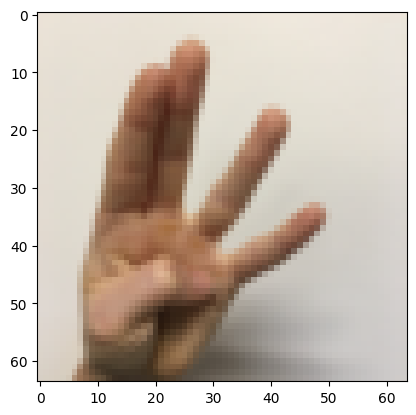

In [49]:
# Example of an image from the dataset
index = 9
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [50]:
# Normalize the pixel values of the images by dividing each pixel value by 255
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Convert the target labels to one-hot vectors
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


#### <font color='green'> Q2.1.1 Describe your dataset.

> **Q2.1.1** : The dataset consists of images of hand signs representing numbers from 0 to 5. There are a total of 1200 examples, with 1080 examples in the training set and 120 examples in the test set. Each image in the dataset has a shape of 64x64x3, indicating that it is a color image with three channels (RGB). 
> 
> The corresponding labels for the images are one-hot encoded, with a shape of (1080, 6) for the training set and (120, 6) for the test set. The dataset is used for training and evaluating a convolutional neural network (CNN), to classify the hand sign images into their respective numbers.

<a name='2.2'></a>
### <font color='darkviolet'> 2.2 - Forward Propagation  </font>

In TensorFlow, there are built-in functions that implement the convolution steps. By now, you should be familiar with how TensorFlow builds computational graphs. In the [Functional API](https://www.tensorflow.org/guide/keras/functional), you create a graph of layers. This is what allows such great flexibility.

However, the following model could also be defined using the Sequential API since the information flow is on a single line. Anyhw, we want you to learn to use the Functional API.

Begin building your graph of layers by creating an input node as a callable object:

- **input_img = tf.keras.Input(shape=input_shape):** 

Then, create a new node in the graph of layers by calling a layer on the `input_img` object: 

- **tf.keras.layers.Conv2D(filters= ... , kernel_size= ... , padding='same')(input_img):** Read the full documentation on [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D).

- **tf.keras.layers.MaxPool2D(pool_size=(f, f), strides=(s, s), padding='same'):** `MaxPool2D()` downsamples your input using a window of size (f, f) and strides of size (s, s) to carry out max pooling over each window.  For max pooling, you usually operate on a single example at a time and a single channel at a time. Read the full documentation on [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D).

- **tf.keras.layers.ReLU():** computes the element-wise ReLU of Z (which can be any shape). You can read the full documentation on [ReLU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU).

- **tf.keras.layers.Flatten()**: given a tensor "P", this function takes each training (or test) example in the batch and flattens it into a 1D vector.  

    * If a tensor P has the shape (batch_size,h,w,c), it returns a flattened tensor with shape (batch_size, k), where $k=h \times w \times c$.  "k" equals the product of all the dimension sizes other than the first dimension.
    
    * For example, given a tensor with dimensions [100, 2, 3, 4], it flattens the tensor to be of shape [100, 24], where 24 = 2 * 3 * 4.  You can read the full documentation on [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten).

- **tf.keras.layers.Dense(units= ... , activation='softmax')(F):** given the flattened input F, it returns the output computed using a fully connected layer. You can read the full documentation on [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense).

In the last function above (`tf.keras.layers.Dense()`), the fully connected layer automatically initializes weights in the graph and keeps on training them as you train the model. Hence, you did not need to initialize those weights when initializing the parameters.

Lastly, before creating the model, you'll need to define the output using the last of the function's compositions (in this example, a Dense layer): 

- **outputs = tf.keras.layers.Dense(units=6, activation='softmax')(F)** 


<a name='ex-2.2.1'></a>
### <font color='green'> Exercise 2.2.1 - convolutional_model  </font>

Implement the `convolutional_model` function below to build the following model: `CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE`. Use the functions above! 

Also, plug in the following parameters for all the steps:

 - [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D): Use 8 filters 4 by 4 , stride 1, padding is "SAME"
 - [ReLU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU)
 - [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D): Use an 8 by 8 filter size and an 8 by 8 stride, padding is "SAME"
 - **Conv2D**: Use 16 filters 2 by 2, stride 1, padding is "SAME"
 - **ReLU**
 - **MaxPool2D**: Use a 4 by 4 filter size and a 4 by 4 stride, padding is "SAME"
 - [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) the previous output.
 - Fully-connected ([Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)) layer: apply a fully connected layer with 6 neurons and a softmax activation. 

In [51]:
def convolutional_model(input_shape):
    """
    Implements a convolutional neural network model using Keras.

    Arguments:
    input_shape -- shape of the input data

    Returns:
    model -- Keras model instance
    """
    
    # Define the input layer
    input_img = tf.keras.Input(shape=input_shape)
    
  
    # CONV2D: 8 filters 4x4, stride of 1, padding 'SAME'
    conv1 = tf.keras.layers.Conv2D(8, (4, 4), strides=(1, 1), padding='SAME')(input_img)
    
    # Apply ReLU activation function
    relu1 = tf.keras.layers.ReLU()(conv1)
    
    # MAXPOOL: window 8x8, stride 8, padding 'SAME'
    maxpool1 = tf.keras.layers.MaxPooling2D((8, 8), strides=(8, 8), padding='SAME')(relu1)
    
    # CONV2D: 16 filters 2x2, stride 1, padding 'SAME'
    conv2 = tf.keras.layers.Conv2D(16, (2, 2), strides=(1, 1), padding='SAME')(maxpool1)
    
    # Apply ReLU activation function
    relu2 = tf.keras.layers.ReLU()(conv2)
    
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    maxpool2 = tf.keras.layers.MaxPooling2D((4, 4), strides=(4, 4), padding='SAME')(relu2)
    
    # Flatten
    flatten = tf.keras.layers.Flatten()(maxpool2)
    
    
    # Dense layer
    # 6 neurons in output layer. Hint: one of the arguments should be "activation='softmax'" 
    out = tf.keras.layers.Dense(6, activation='softmax')(flatten)
    
    # Define the Keras model
    model = tf.keras.Model(inputs=input_img, outputs=out)
    
    return model

In [52]:
conv_model = convolutional_model((64, 64, 3))
conv_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
conv_model.summary()
    
output = [['InputLayer', [(None, 64, 64, 3)], 0],
        ['Conv2D', (None, 64, 64, 8), 392, 'same', 'linear', 'GlorotUniform'],
        ['ReLU', (None, 64, 64, 8), 0],
        ['MaxPooling2D', (None, 8, 8, 8), 0, (8, 8), (8, 8), 'same'],
        ['Conv2D', (None, 8, 8, 16), 528, 'same', 'linear', 'GlorotUniform'],
        ['ReLU', (None, 8, 8, 16), 0],
        ['MaxPooling2D', (None, 2, 2, 16), 0, (4, 4), (4, 4), 'same'],
        ['Flatten', (None, 64), 0],
        ['Dense', (None, 6), 390, 'softmax']]
comparator(summary(conv_model), output)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 8)         392       
                                                                 
 re_lu_9 (ReLU)              (None, 64, 64, 8)         0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 8, 8, 8)          0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 8, 16)          528       
                                                                 
 re_lu_10 (ReLU)             (None, 8, 8, 16)          0         
                                                           

Both the Sequential and Functional APIs return a TF Keras model object. The only difference is how inputs are handled inside the object model.

#### <font color='green'> Q2.2.1 How to compute the number of parameters reported per layer? 

> **Q2.2.1 ANSWER**:
> 
> The number of parameters reported in the table is calculated as follows:
> 
> - **For Conv2D layers**: The number of parameters is calculated as `(filter_height * filter_width * input_channels + 1) * number_of_filters`. In the given summary, the first Conv2D layer has a filter size of 4 * 4, input channels of 3 (RGB image), and 8 filters, so the total number of parameters for this layer is `(4 * 4 * 3 + 1) * 8 = 392`. Similarly, for the second Conv2D layer, with a filter size of 3 * 3, input channels of 8, and 16 filters, the total number of parameters is `(2 * 2 * 8 + 1) * 16 = 528`.
> 
> - **For Dense layers**: The number of parameters is calculated as `(number_of_input_neurons + 1) * number_of_output_neurons`. In the given summary, the Dense layer has 64 input neurons (output of the Flatten layer) and 6 output neurons, so the total number of parameters for this layer is `(64 + 1) x 6 = 390`.
> 
> - **For other layers** (e.g., ReLU, MaxPooling2D, Flatten): These layers do not have any parameters, so the number of parameters is 0.
> 
> - **For InputLayer**: Input layers do not have any parameters, so the number of parameters is 0.
> 
> - **The total number of trainable parameters** in the model is the sum of the parameters from all layers that are marked as trainable during model compilation. In this > case, the total number of trainable parameters is 1,310, which is the sum of the parameters from Conv2D and Dense layers in the model.
> 


<a name='2.3'></a>
### <font color='darkviolet'> 2.3 - Train the Model

In [53]:
# create train and test datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(64)

In [54]:
# Print the size of the train_dataset
train_size = tf.data.experimental.cardinality(train_dataset).numpy()
print('Number of batches in train_dataset:', train_size)
print('Number of samples in train_dataset:', train_size * 64)

# Print the size of the test_dataset
test_size = tf.data.experimental.cardinality(test_dataset).numpy()
print('Number of batches in test_dataset:', test_size)
print('Number of samples in test_dataset:', test_size * 64)

Number of batches in train_dataset: 17
Number of samples in train_dataset: 1088
Number of batches in test_dataset: 2
Number of samples in test_dataset: 128


In [55]:
# Print the contents of the first batch of the train_dataset
for X, Y in train_dataset.take(1):
    print('Shape of input features (X):', X.shape)
    print('Shape of labels (Y):', Y.shape)
    print('Input features (X):', X)
    print('Labels (Y):', Y)

Shape of input features (X): (64, 64, 64, 3)
Shape of labels (Y): (64, 6)
Input features (X): tf.Tensor(
[[[[0.89019608 0.8627451  0.83921569]
   [0.89019608 0.86666667 0.84313725]
   [0.89019608 0.87058824 0.84313725]
   ...
   [0.90980392 0.90196078 0.87843137]
   [0.90588235 0.89803922 0.87058824]
   [0.90196078 0.89803922 0.86666667]]

  [[0.89019608 0.86666667 0.83921569]
   [0.89019608 0.86666667 0.84313725]
   [0.89411765 0.86666667 0.84313725]
   ...
   [0.90980392 0.90196078 0.87843137]
   [0.90588235 0.89803922 0.87058824]
   [0.90588235 0.89803922 0.86666667]]

  [[0.89019608 0.86666667 0.83921569]
   [0.89019608 0.86666667 0.83921569]
   [0.89019608 0.86666667 0.84313725]
   ...
   [0.90980392 0.90196078 0.87843137]
   [0.90588235 0.89803922 0.8745098 ]
   [0.90196078 0.89803922 0.86666667]]

  ...

  [[0.46666667 0.31764706 0.2       ]
   [0.48627451 0.33333333 0.21568627]
   [0.49803922 0.34117647 0.22745098]
   ...
   [0.82352941 0.82745098 0.82745098]
   [0.82745098 0.8

In [56]:
# Compile the model
conv_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Train the model
history = conv_model.fit(train_dataset,
                          epochs=100,
                          validation_data=test_dataset,
                          verbose=2)

Epoch 1/100
17/17 - 1s - loss: 1.8217 - accuracy: 0.1417 - val_loss: 1.7899 - val_accuracy: 0.1833 - 1s/epoch - 60ms/step
Epoch 2/100
17/17 - 1s - loss: 1.7859 - accuracy: 0.2065 - val_loss: 1.7844 - val_accuracy: 0.1583 - 612ms/epoch - 36ms/step
Epoch 3/100
17/17 - 1s - loss: 1.7801 - accuracy: 0.2250 - val_loss: 1.7784 - val_accuracy: 0.2167 - 608ms/epoch - 36ms/step
Epoch 4/100
17/17 - 1s - loss: 1.7739 - accuracy: 0.2759 - val_loss: 1.7720 - val_accuracy: 0.2917 - 505ms/epoch - 30ms/step
Epoch 5/100
17/17 - 1s - loss: 1.7677 - accuracy: 0.3157 - val_loss: 1.7664 - val_accuracy: 0.2833 - 507ms/epoch - 30ms/step
Epoch 6/100
17/17 - 1s - loss: 1.7616 - accuracy: 0.3528 - val_loss: 1.7591 - val_accuracy: 0.3667 - 508ms/epoch - 30ms/step
Epoch 7/100
17/17 - 0s - loss: 1.7539 - accuracy: 0.3806 - val_loss: 1.7505 - val_accuracy: 0.3833 - 498ms/epoch - 29ms/step
Epoch 8/100
17/17 - 1s - loss: 1.7452 - accuracy: 0.3870 - val_loss: 1.7392 - val_accuracy: 0.3917 - 502ms/epoch - 30ms/step
Epo

<a name='2.4'></a>
### <font color='darkviolet'> 2.4 - History

The history object is an output of the `.fit()` operation, and provides a record of all the loss and metric values in memory. It's stored as a dictionary that you can retrieve at `history.history`:

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

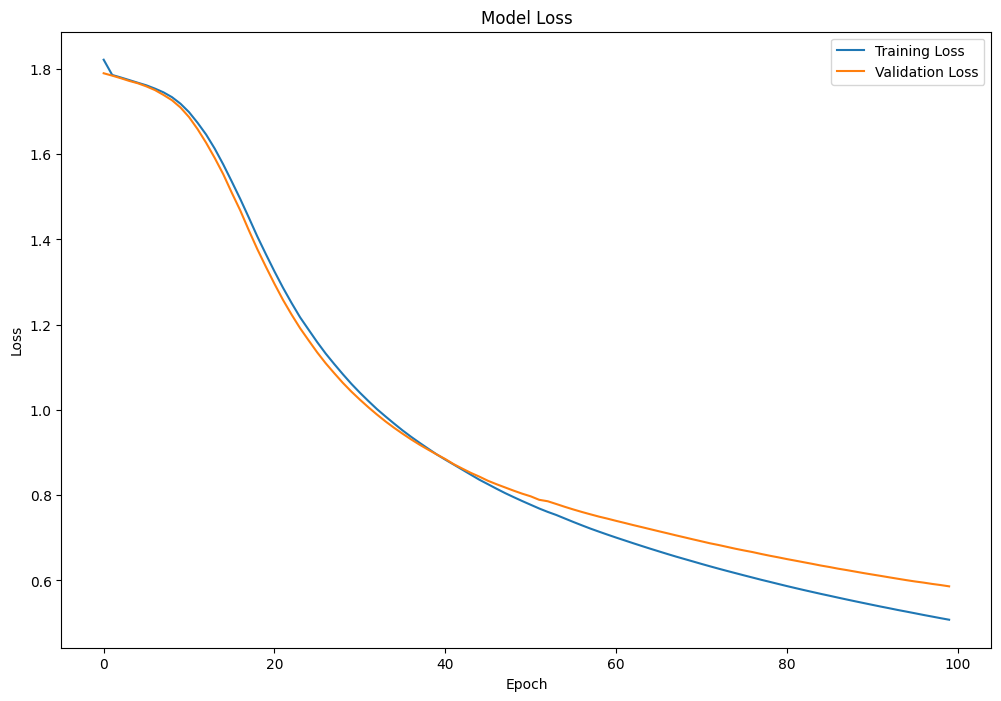

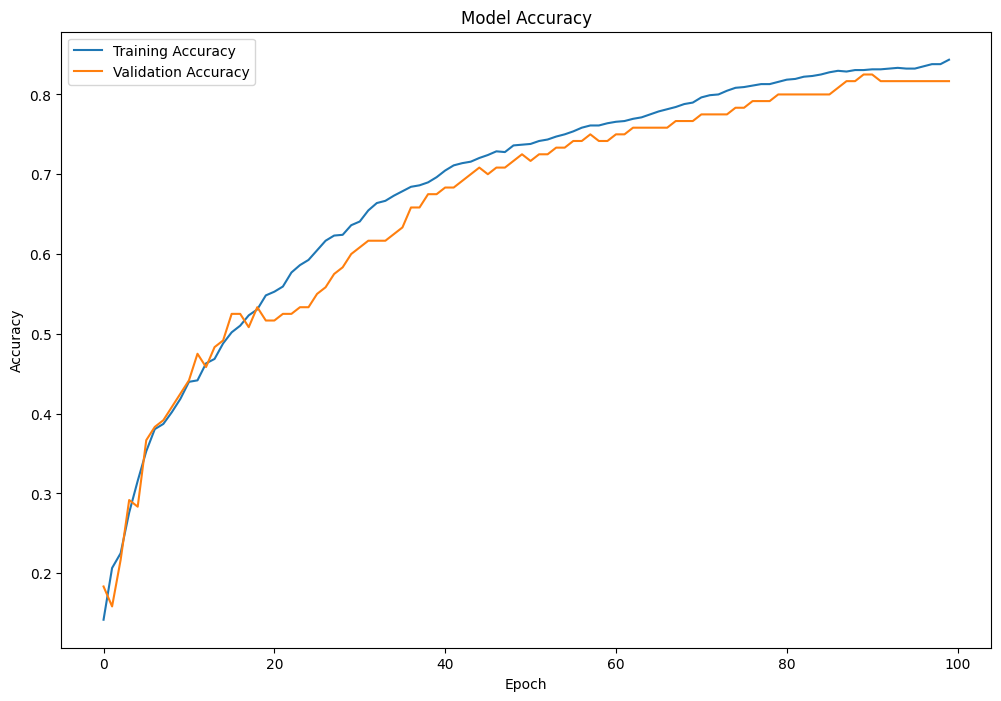

In [57]:
# Create a DataFrame with the loss and accuracy values
df_loss_acc = pd.DataFrame(history.history)

# Extract the training and validation loss values and rename the columns
df_loss = df_loss_acc[['loss', 'val_loss']]
df_loss = df_loss.rename(columns={'loss': 'Training Loss', 'val_loss': 'Validation Loss'})

# Extract the training and validation accuracy values and rename the columns
df_acc = df_loss_acc[['accuracy', 'val_accuracy']]
df_acc = df_acc.rename(columns={'accuracy': 'Training Accuracy', 'val_accuracy': 'Validation Accuracy'})

# Plot the training and validation loss values
df_loss.plot(title='Model Loss', figsize=(12, 8)).set(xlabel='Epoch', ylabel='Loss')

# Plot the training and validation accuracy values
df_acc.plot(title='Model Accuracy', figsize=(12, 8)).set(xlabel='Epoch', ylabel='Accuracy')

#### <font color='green'> Q2.4.1 Observe your training history and describe. </font>


> The training history shows that the model is improving in terms of loss and accuracy over the epochs. The loss gradually decreases, and the accuracy increases logarithmically. The validation curves closely follow the training curves, indicating good generalization. 
> 
> However, slight overfitting may be observed as the validation loss is slightly higher and the validation accuracy is slightly lower than the training values. Overall, the model is learning from the data and performing well, but further analysis and fine-tuning may be needed based on specific requirements.

<a name='ex-3'></a>
### <font color='green'> Exercise 3 - output volume computation  </font>
    
You have an input volume that is 32 x 32 x 16, and apply max pooling with a stride of 2 and a filter size of 2.
    
What is the output volume?

> Informations : 
> - input volume = 32 x 32 x 16
> - stride (s) = 2
> - filter size = 2
>
> $$ output volume = (n + 2p - f)/s + 1 $$ 
> $$ output volume = (32 + 2 \times 0 - 2)/2 + 1 = 16 $$
>
> So the output volume is **16 x 16 x 16**.
